In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt 

Загрузите датасет digits с помощью функции load_digits из sklearn.datasets и подготовьте матрицу признаков X и ответы на обучающей выборке y (вам потребуются поля data и target в объекте, который возвращает load_digits). 

In [2]:
from sklearn.datasets import load_digits
df = load_digits()

In [6]:
x = df.data
y = df.target 

Для оценки качества далее нужно будет использовать cross_val_score из sklearn.cross_validation с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Мы предлагаем использовать k=10, чтобы полученные оценки качества имели небольшой разброс, и было проще проверить полученные ответы. На практике же часто хватает и k=5. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) вызовите метод .mean() у массива, который возвращает cross_val_score.

In [7]:
from sklearn.model_selection import cross_val_score

Создайте DecisionTreeClassifier с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score

In [9]:
from sklearn import tree 
dtc = tree.DecisionTreeClassifier()
cross_val_score(dtc, x, y, cv = 10).mean()

0.82971149558900914

Воспользуйтесь BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100

In [11]:
from sklearn.ensemble import BaggingClassifier
bag_cl = BaggingClassifier(n_estimators  = 100)
cross_val_score(bag_cl, x, y, cv = 10).mean()

0.92598715619966487

Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на d\sqrt{d}d
​ случайных признаков. 

Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков.

In [21]:
import math
bag_cl_2 = BaggingClassifier(n_estimators  = 100, max_features = int(math.sqrt(x.shape[1])))
cross_val_score(bag_cl_2, x, y, cv = 10).mean()

0.93325100838603758

Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier.

In [22]:
dtc_2 = tree.DecisionTreeClassifier(max_features = int(math.sqrt(x.shape[1])))
bag_cl_3 = BaggingClassifier(base_estimator = dtc_2, n_estimators  = 100)
cross_val_score(bag_cl_3, x, y, cv = 10).mean()

0.95498473429212383

Полученный в предыдущем пункте классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest, поэтому почему бы не сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble. Сделайте это, а затем изучите, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева. 

In [23]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
cross_val_score(rfc, x, y, cv = 10).mean()

0.91999849661848532

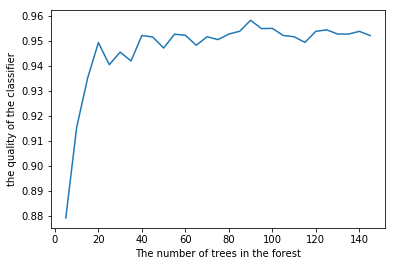

In [32]:
score = []
for i in range(5, 150, 5):
    rfc = RandomForestClassifier(n_estimators = i)
    score.append(cross_val_score(rfc, x, y, cv = 10, n_jobs = 5).mean())

plt.plot(range(5, 150, 5), score)
plt.xlabel('The number of trees in the forest')
plt.ylabel('the quality of the classifier')
plt.show()

##### Верны утверждения:

    1) При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев
    
    2) С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется.

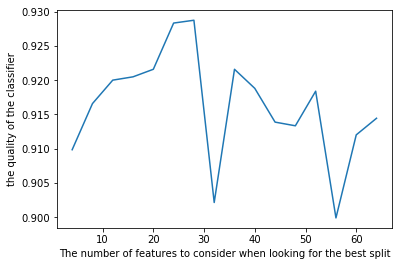

In [28]:
score = []
for i in range(4, 65, 4):
    rfc = RandomForestClassifier(max_features = i)
    score.append(cross_val_score(rfc, x, y, cv = 10, n_jobs = 5).mean())

plt.plot(range(4, 65, 4), score)
plt.xlabel('The number of features to consider when looking for the best split')
plt.ylabel('the quality of the classifier')
plt.show()

##### Верно утверждение:
При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.

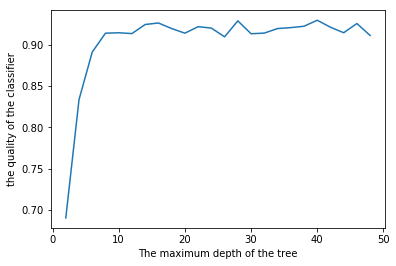

In [33]:
score = []
for i in range(2, 50, 2):
    rfc = RandomForestClassifier(max_depth  = i)
    score.append(cross_val_score(rfc, x, y, cv = 10, n_jobs = 5).mean())

plt.plot(range(2, 50, 2), score)
plt.xlabel('The maximum depth of the tree')
plt.ylabel('the quality of the classifier')
plt.show()

##### Верно утверждение:
При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).